Note: you may need to restart the kernel to use updated packages.
Raw data shape: (50440, 55, 100)
Raw label distribution: [32197 18243]
Normalized shape: (50440, 55, 100)
After SMOTE shape: (68752, 55, 100)
After SMOTE label distribution: [34376 34376]
Train/Val/Test: (55001, 55, 100) (6875, 55, 100) (6876, 55, 100)
Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.5105 - loss: 0.7015 - val_accuracy: 0.5111 - val_loss: 0.6906
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5206 - loss: 0.6916 - val_accuracy: 0.5411 - val_loss: 0.6891
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5274 - loss: 0.6898 - val_accuracy: 0.5327 - val_loss: 0.6886
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5317 - loss: 0.6894 - val_accuracy: 0.5271 - val_loss: 0.6900
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5364 - loss: 0.6876 - val_accuracy: 0.5344 - val_loss: 0.6866
Epoch 6/10
1719/1719 ━━━━━

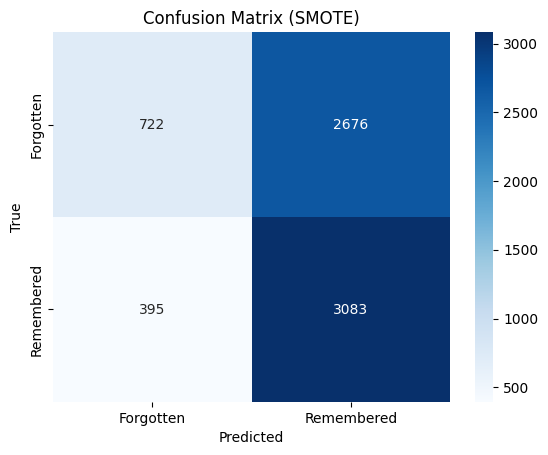

              precision    recall  f1-score   support

           0       0.65      0.21      0.32      3398
           1       0.54      0.89      0.67      3478

    accuracy                           0.55      6876
   macro avg       0.59      0.55      0.49      6876
weighted avg       0.59      0.55      0.50      6876

Accuracy: 0.5533740546829552


In [1]:
%pip install -q imbalanced-learn tensorflow
import numpy as np
import h5py
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D, BatchNormalization, Activation, AveragePooling2D, Dropout, Flatten, Dense, Embedding, Concatenate)
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

# Load and preprocess data
X_all = []
y_all = []
subject_ids = []

ch_ch = list(range(63))
g_ch = list(range(61))
ch_rem = [0, 2, 6, 8, 29, 31, 51, 55]
g_rem = [46, 49, 56, 58, 59, 60]

for i in ch_rem:
    ch_ch.remove(i)
for j in g_rem:
    g_ch.remove(j)

# Load Chinese dataset (Subjects 0-4 -> internal IDs 0-3)
for subj in range(1, 10):
    file_path = fr'C:\Users\USER\Desktop\RA\data_ch\ASK\sbj_{subj}.mat'
    try:
        mat_data = loadmat(file_path)
        X = np.array(mat_data['x_post'])[:-1, ch_ch, :]
        y = np.array(mat_data['label_next_ind'])[0, :]
        X = np.transpose(X)
        X_all.append(X)
        y_all.append(y)
        subject_ids.extend([subj - 1] * X.shape[0])
    except Exception as e:
        print(f'Error loading file {file_path}: {e}')

# Load Korean dataset (Subjects 5-11 -> internal IDs 8.. ? original code added +3 offset)
for subj in range(1, 15):
    file_path = fr'C:\Users\USER\Desktop\RA\data\ASK\sbj_{subj}.mat'
    try:
        with h5py.File(file_path, 'r') as f:
            X = np.array(f['x_post'])[:, g_ch, :]
            y = np.array(f['label_next_ind'])[:, 0]
            X_all.append(X)
            y_all.append(y)
            subject_ids.extend([subj + 3] * X.shape[0])  # keep same offset as original
    except OSError as e:
        print(f'Error loading file {file_path}: {e}')

# Convert lists to numpy arrays
data = np.concatenate(X_all, axis=0)
labels = np.concatenate(y_all, axis=0)
subject_ids = np.array(subject_ids)
print('Raw data shape:', data.shape)
print('Raw label distribution:', np.bincount(labels.astype(int)))

# Normalize data
data_flattened = data.reshape(data.shape[0], -1)
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_flattened).reshape(data.shape)
print('Normalized shape:', data_normalized.shape)

# SMOTE per subject
balanced_data = []
balanced_labels = []
balanced_subjects = []
problem_subjects = []

for subj in np.unique(subject_ids):
    subj_mask = subject_ids == subj
    X_subj, y_subj = data_normalized[subj_mask], labels[subj_mask]
    counts = np.bincount(y_subj.astype(int))
    # Need at least 2 classes and at least 2 samples in minority for default k_neighbors=5. Adjust k dynamically.
    if len(counts) < 2 or np.min(counts[counts > 0]) < 2:
        # Cannot apply SMOTE; keep original
        balanced_data.append(X_subj)
        balanced_labels.append(y_subj)
        balanced_subjects.append(np.full(y_subj.shape, subj))
        problem_subjects.append((int(subj), counts.tolist()))
        continue
    # Choose k_neighbors = min(5, minority_count - 1)
    minority_count = np.min(counts[counts > 0])
    k_neighbors = max(1, min(5, minority_count - 1))
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_res, y_res = smote.fit_resample(X_subj.reshape(X_subj.shape[0], -1), y_subj)
    balanced_data.append(X_res.reshape(X_res.shape[0], *data.shape[1:]))
    balanced_labels.append(y_res)
    balanced_subjects.append(np.full(y_res.shape, subj))

data_balanced = np.concatenate(balanced_data)
labels_balanced = np.concatenate(balanced_labels)
subject_ids_balanced = np.concatenate(balanced_subjects)
subject_ids_balanced = np.clip(subject_ids_balanced, 0, 11)
print('After SMOTE shape:', data_balanced.shape)
print('After SMOTE label distribution:', np.bincount(labels_balanced.astype(int)))
if problem_subjects:
    print('Subjects without SMOTE (kept original):', problem_subjects)

# Train/Test Split (Stratified by Subject)
X_train, X_temp, y_train, y_temp, subj_train, subj_temp = train_test_split(
    data_balanced, labels_balanced, subject_ids_balanced, test_size=0.2, random_state=42, stratify=subject_ids_balanced
)
X_val, X_test, y_val, y_test, subj_val, subj_test = train_test_split(
    X_temp, y_temp, subj_temp, test_size=0.5, random_state=42, stratify=subj_temp
)

print('Train/Val/Test:', X_train.shape, X_val.shape, X_test.shape)

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Define EEGNet model
def EEGNet_with_subject(nb_classes=2, Chans=55, Samples=100, nb_subjects=12, dropoutRate=0.5):
    eeg_input = Input(shape=(Chans, Samples, 1), name='EEG_Input')
    subject_input = Input(shape=(1,), dtype='int32', name='Subject_Input')
    subject_embedding = Embedding(input_dim=nb_subjects, output_dim=8)(subject_input)
    subject_embedding = Flatten()(subject_embedding)
    x = Conv2D(16, (1, 10), padding='same', use_bias=False)(eeg_input)
    x = BatchNormalization()(x)
    x = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=2, depthwise_constraint=tf.keras.constraints.max_norm(1.))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropoutRate)(x)
    x = SeparableConv2D(16, (1, 10), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropoutRate)(x)
    x = Flatten()(x)
    x = Concatenate()([x, subject_embedding])
    x = Dense(nb_classes, activation='sigmoid')(x)
    return Model(inputs=[eeg_input, subject_input], outputs=x)

model = EEGNet_with_subject(nb_classes=2, nb_subjects=12)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Prepare inputs (add channel dim & subject)
X_train_in = [X_train, np.expand_dims(subj_train, axis=-1)]
X_val_in = [X_val, np.expand_dims(subj_val, axis=-1)]
X_test_in = [X_test, np.expand_dims(subj_test, axis=-1)]

history = model.fit(X_train_in, y_train_cat, epochs=10, batch_size=32, verbose=1, validation_data=(X_val_in, y_val_cat))

# Evaluate
y_pred = model.predict(X_test_in)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Forgotten','Remembered'], yticklabels=['Forgotten','Remembered'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SMOTE)')
plt.show()
print(classification_report(y_true_labels, y_pred_labels))
from sklearn.metrics import accuracy_score
print('Accuracy:', accuracy_score(y_true_labels, y_pred_labels))